# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2024

Мягкий дедлайн: 22.12.2024 23:59 MSK

Жёсткий дедлайн: 22.12.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность, так что заодно научимся, как его правильно готовить

In [90]:
from warnings import filterwarnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [27]:
X = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

X_train.shape, X_valid.shape, X_test.shape

((18825, 169), (2354, 169), (2353, 169))

---

## Задание 1. Базовый градиентный бустинг (4 балла)

Первая часть посвящена реализации собственного градиентного бустинга. Обращаем внимание, что пользоваться готовыми реализациями <font color='lightcoral'>**нельзя**</font>, если специально не оговорено. На все <font color='plum'>**вопросы**</font> должен быть <font color='plum'>**ответ**</font>. В заданиях есть референсы для параметров, которые нужно сделать, на случай, если объяснение из ноутбука непонятно, тогда советуем обратиться к соответствующей документации

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

Обязательные параметры:
 — `base_model_class` — класс базовой модели нашего бустинга
 — `base_model_params` — словарь с гиперпараметрами для базовой модели
 — `n_estimators` — какое количество базовых моделей нужно обучить
 — `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$

#### `fit`

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (используем `loss_fn` для этого) и найти новую оптимальную гамму

После всего цикла обучения надо нарисовать график (если `plot=True`).

#### `partial_fit`

В `partial_fit` приходит обучающая выборка, на которую обучается новая базовая модель

#### `predict_proba`

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

#### `plot_history`

В `plot_history` приходит любая выборка, для которой последовательно считаются значения функции потерь и/или любой метрики, которую вы хотите посчитать, путем последовательного применения базовых моделей. Можно делать сразу во время обучения, можно делать иначе

In [29]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
%autoreload 2

from boosting import Boosting

### Проверка кода

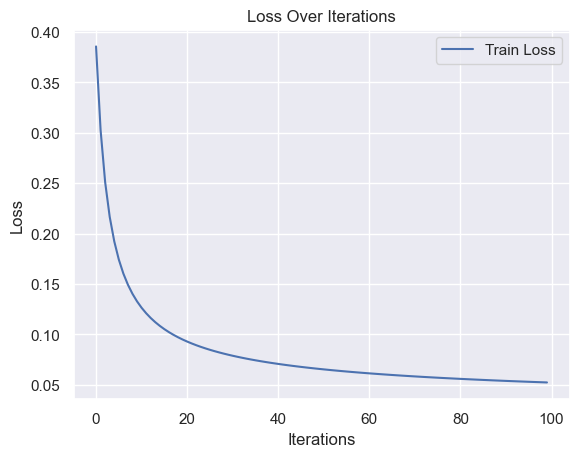

Train ROC-AUC 0.9998
Valid ROC-AUC 0.8647
Test ROC-AUC 0.8599


In [77]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

---

## Задание 2. Имплементация гиперпараметров (2.5 балла + 3.5 бонус)

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации безотносительно базовой модели. В этом пункте предлагается имплементировать часть из них. При необходимости можете обратиться к реализациям в вашей любимой библиотеке, там могут быть дополнительные пояснения и/или ссылки на оригинальные статьи

<font color='lightcoral'>**Важно!**</font> После добавления каждого параметра проверьте, как это повлияет на качество. Специально крутить параметры не нужно, но важно увидеть, что перформанс модели изменился, в худшую или в лучшую сторону, для этого какие-то параметры нужны, пусть и от балды, <font color='lightcoral'>**дефолтные параметры не подойдут**</font>, они скорее для референса. Лучше всего это видно по графикам обучения <font color='lightcoral'>**на трейне и валидации**</font>, рекомендуется смотрить именно на них

### 2.1. Борьба с переобучением (0.5 балла)

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации. Реализуйте такую процедуру, не забудьте, что всю предобработку, что вы будете делать для трейна, нужно будет повторить на валидации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| <td colspan=3>`early_stopping_rounds`, `eval_set` |

Добавьте параметры:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `X_val`, `y_val` или `eval_set: Tuple[np.ndarray] | None = None` — валидацонная выборка, на которой будем проверять переобучение

In [40]:
%pip install tabulate
from tabulate import tabulate


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Testing early stopping:   0%|          | 0/5 [00:00<?, ?it/s]


Testing early_stopping_rounds=1...

Early STOP at iteration 3


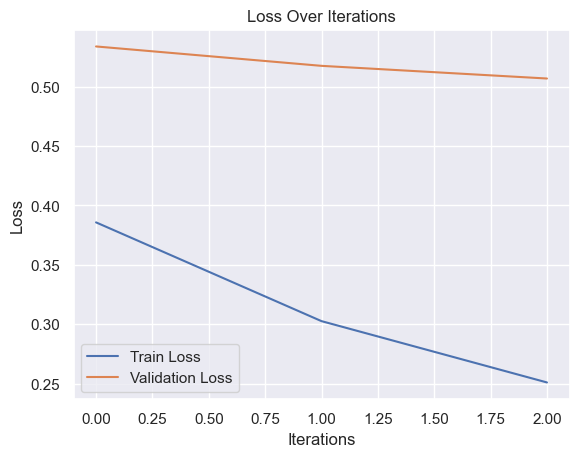

Testing early stopping:  20%|██        | 1/5 [00:01<00:06,  1.50s/it]

+---------------+-----------------------+--------------------------+
| Metric        |   With early stopping |   Without early stopping |
+===============+=======================+==========================+
| Train ROC-AUC |                0.9998 |                   0.9998 |
+---------------+-----------------------+--------------------------+
| Valid ROC-AUC |                0.9012 |                   0.8647 |
+---------------+-----------------------+--------------------------+
| Test ROC-AUC  |                0.8985 |                   0.8599 |
+---------------+-----------------------+--------------------------+



Testing early_stopping_rounds=11...

Early STOP at iteration 15


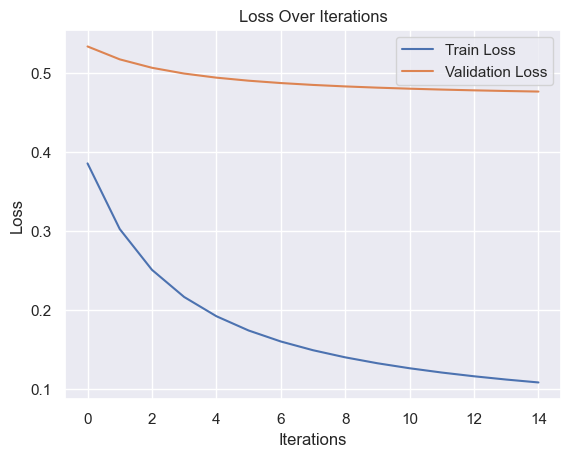

Testing early stopping:  40%|████      | 2/5 [00:07<00:12,  4.05s/it]

+---------------+-----------------------+--------------------------+
| Metric        |   With early stopping |   Without early stopping |
+===============+=======================+==========================+
| Train ROC-AUC |                0.9998 |                   0.9998 |
+---------------+-----------------------+--------------------------+
| Valid ROC-AUC |                0.8965 |                   0.8647 |
+---------------+-----------------------+--------------------------+
| Test ROC-AUC  |                0.8909 |                   0.8599 |
+---------------+-----------------------+--------------------------+



Testing early_stopping_rounds=21...

Early STOP at iteration 25


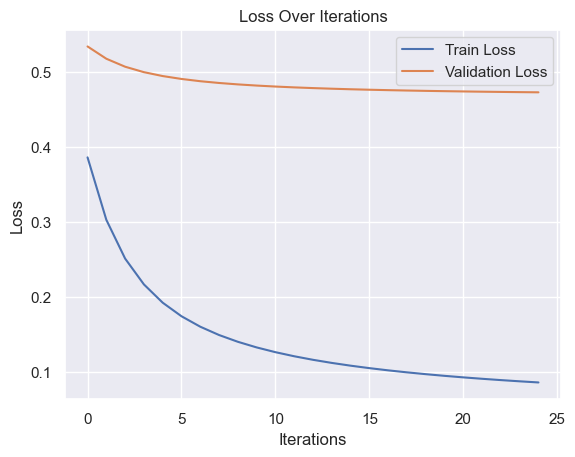

Testing early stopping:  60%|██████    | 3/5 [00:16<00:13,  6.57s/it]

+---------------+-----------------------+--------------------------+
| Metric        |   With early stopping |   Without early stopping |
+===============+=======================+==========================+
| Train ROC-AUC |                0.9998 |                   0.9998 |
+---------------+-----------------------+--------------------------+
| Valid ROC-AUC |                0.8921 |                   0.8647 |
+---------------+-----------------------+--------------------------+
| Test ROC-AUC  |                0.8863 |                   0.8599 |
+---------------+-----------------------+--------------------------+



Testing early_stopping_rounds=31...

Early STOP at iteration 35


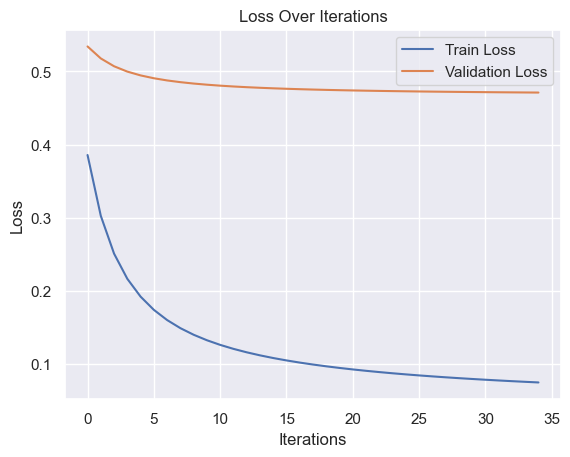

Testing early stopping:  80%|████████  | 4/5 [00:30<00:09,  9.35s/it]

+---------------+-----------------------+--------------------------+
| Metric        |   With early stopping |   Without early stopping |
+===============+=======================+==========================+
| Train ROC-AUC |                0.9998 |                   0.9998 |
+---------------+-----------------------+--------------------------+
| Valid ROC-AUC |                0.8756 |                   0.8647 |
+---------------+-----------------------+--------------------------+
| Test ROC-AUC  |                0.8693 |                   0.8599 |
+---------------+-----------------------+--------------------------+



Testing early_stopping_rounds=41...

Early STOP at iteration 45


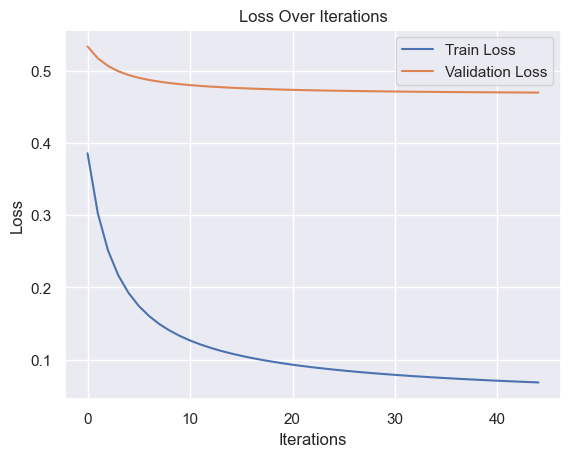

Testing early stopping: 100%|██████████| 5/5 [00:48<00:00,  9.66s/it]

+---------------+-----------------------+--------------------------+
| Metric        |   With early stopping |   Without early stopping |
+===============+=======================+==========================+
| Train ROC-AUC |                0.9998 |                   0.9998 |
+---------------+-----------------------+--------------------------+
| Valid ROC-AUC |                0.8995 |                   0.8647 |
+---------------+-----------------------+--------------------------+
| Test ROC-AUC  |                0.8946 |                   0.8599 |
+---------------+-----------------------+--------------------------+




In [ ]:
from tqdm import tqdm
from tabulate import tabulate

for i in tqdm(range(1, 51, 10), desc="Testing early stopping"):
    print(f"\nTesting early_stopping_rounds={i}...\n")
    
    boosting_model_with_early_stopping = Boosting(
        n_estimators=100,
        learning_rate=0.1,
        early_stopping_rounds=i
    )

    boosting_model_with_early_stopping.fit(
        X_train, 
        y_train,
        eval_set=[(X_valid, y_valid)],  
        plot=False
    )

    boosting_model_with_early_stopping.plot_history(X_valid, y_valid)

    data = [
        ["Train ROC-AUC", 
         f"{boosting_model_with_early_stopping.score(X_train, y_train):.4f}",
         f"{boosting.score(X_train, y_train):.4f}"],
        ["Valid ROC-AUC",
         f"{boosting_model_with_early_stopping.score(X_valid, y_valid):.4f}", 
         f"{boosting.score(X_valid, y_valid):.4f}"],
        ["Test ROC-AUC",
         f"{boosting_model_with_early_stopping.score(X_test, y_test):.4f}",
         f"{boosting.score(X_test, y_test):.4f}"]
    ]

    headers = ["Metric", "With early stopping", "Without early stopping"]
    print(tabulate(data, headers=headers, tablefmt="grid"))
    print("\n")


### Бонус. Бустинг линейных моделей (0.5 балла)

**<font color='plum'>Вопрос:** что произойдет при ансамблировании линейных моделей? Имеет ли это смысл?</font>

<font color='plum'>**Ответ:** Ну по логике все зависит от  того как мы делаем. Условно если мы усредним много линейных моделей, то мб итоговая и будет близка тоже к линейной так как линейная комбинация дает линейность (в контексте функций). В целом за счет ансамблирования можно уменшить чувствительность к шуму как пример. Насчет смысла - вообще смысл дело такое, сложное, если у нас данные шумные/данные обучены на разных данных (беггинг) то да в целом можно ансамбль линейных моделей сделать. Но очев что если у нас сложные зависимости или просто почти любая ситуация кроме описанных выше то линейные модели будут не оч.</font>

Давайте убедимся. Обучите бустинг, где в качестве базовой модели будет линейная регрессия. Обязательно сохраните историю функции потерь и зафиксируйте время обучения. Можно взять уже готовый из <font color='lightblue'>**XGBoost**</font>, но будьте готовы разобраться с тем, как оттуда достать историю обучения

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="gblinear")` | — | — |

In [51]:
%pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB 7.0 MB/s eta 0:00:18
   ---------------------------------------- 0.3/124.9 MB 7.0 MB/s eta 0:00:18
    --------------------------------------- 2.6/124.9 MB 14.9 MB/s eta 0:00:09
   - -------------------------------------- 3.7/124.9 MB 16.7 MB/s eta 0:00:08
   - -------------------------------------- 4.4/124.9 MB 17.4 MB/s eta 0:00:07
   - -------------------------------------- 5.3/124.9 MB 17.9 MB/s eta 0:00:07
   - -------------------------------------- 6.2/124.9 MB 17.1 MB/s eta 0:00:07
   -- ------------------------------------- 6.6/124.9 MB 16.9 MB/s eta 0:00:07
   -- ------------------------------------- 6.8/124.9 MB 15.5 MB/s eta 0:00:08
   -- ------------------------------------- 7.5/124.9 MB 15.3 MB/s eta 0:00:08
   -- ------------------------------------- 7.6/124.9 MB 14.3 MB/s eta


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


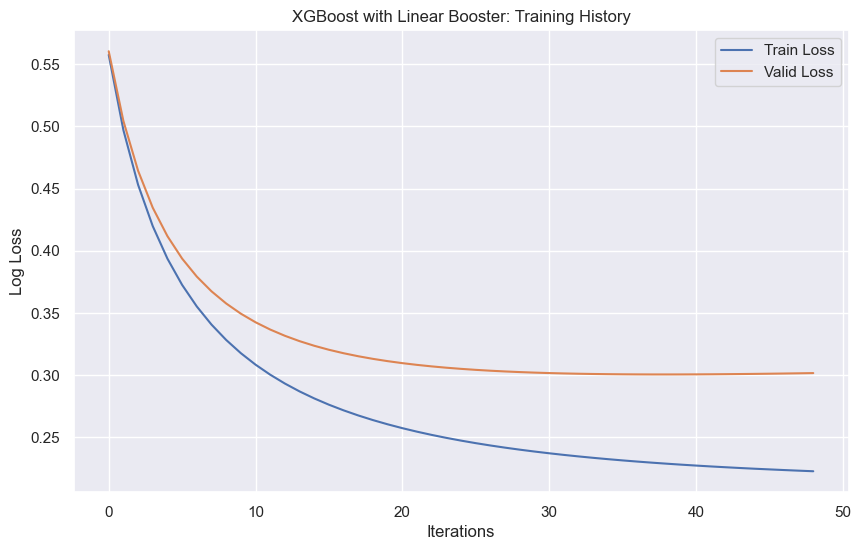

Training time: 1734811974.78 seconds
Train ROC-AUC: 0.9690
Valid ROC-AUC: 0.9395


In [ ]:
import xgboost as xgb
import time
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# dmatrix это внутренний формат данных xgboost он хранится в формате признаки и лейблы
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
valid_dmatrix = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'booster': 'gblinear',  # линбустер 
    'objective': 'binary:logistic',  # логрег
    'eta': 0.1,  # авг 
    'seed': 1337,  # авг
    'eval_metric': 'logloss'  # метрика 
}

start_time = time.time()
evals_result = {}
model_xgb= xgb.train(
    params,
    train_dmatrix,
    num_boost_round=100,  # кол-во итераций прост рандом взял
    evals=[(train_dmatrix, 'train'), (valid_dmatrix, 'valid')],  
    early_stopping_rounds=10,  
    evals_result=evals_result,  
    verbose_eval=False  
)
train_time_xgb = time.time() 

# беру метрики из evals_result
train_loss_xgb = evals_result['train']['logloss']
valid_loss_xgb= evals_result['valid']['logloss']

# графики (чат гипете построил)
plt.figure(figsize=(10, 6))
plt.plot(train_loss_xgb, label='Train Loss')
plt.plot(valid_loss_xgb, label='Valid Loss')
plt.title('XGBoost with Linear Booster: Training History')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

print(f"Training time: {train_time_xgb:.2f} seconds")
print(f"Train ROC-AUC: {roc_auc_score(y_train, model_xgb.predict(train_dmatrix)):.4f}")
print(f"Valid ROC-AUC: {roc_auc_score(y_valid, model_xgb.predict(valid_dmatrix)):.4f}")


Теперь возьмите `sklearn.linear_model.SGDClassifier` иобучите на тех же данных. Не забудьте вытащить историю функции потерь

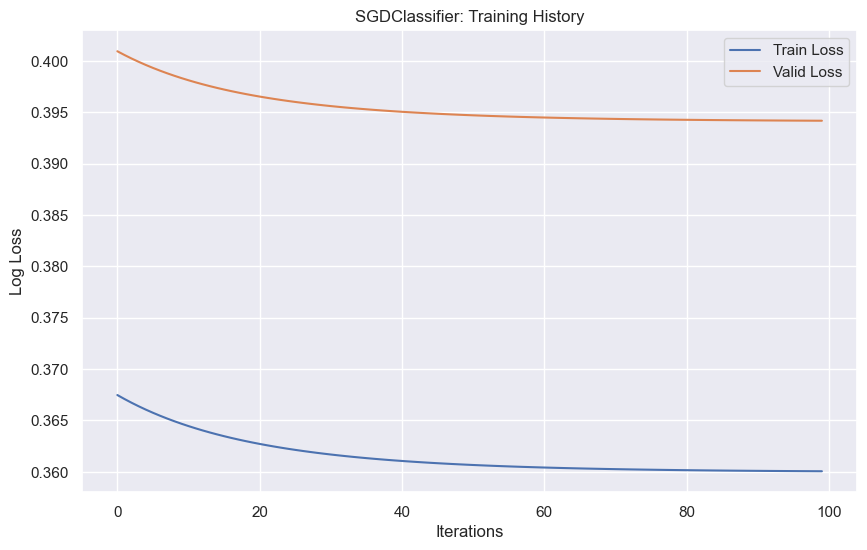

Train ROC-AUC: 0.9263
Valid ROC-AUC: 0.9060


In [80]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.special import expit  

sgd = SGDClassifier(
    loss='log_loss',  # логистическая регрессия
    penalty='l2',  # L2-регуляризация
    alpha=0.1,  # коэффициент регуляризации
    learning_rate='adaptive',  # константный темп обучения не вышел, пробую адаптивный
    eta0=0.01,  # темп обучения
    max_iter=1,  # 1 обновление весов за вызов fit
    warm_start=True,  
    random_state=1337
)

scaler = StandardScaler(with_mean=False)  
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

train_loss_metrics_sgd= []
valid_loss_metrics_sgd = []
start_time_sgd = time.time()

for epoch in range(100):  
    sgd.fit(X_train_normalized, y_train)

    train_proba = expit(sgd.decision_function(X_train_normalized))
    valid_proba = expit(sgd.decision_function(X_valid_normalized))

    train_loss = log_loss(y_train, train_proba)
    valid_loss = log_loss(y_valid, valid_proba)

    train_loss_metrics_sgd.append(train_loss)
    valid_loss_metrics_sgd.append(valid_loss)
sgd_time = time.time() - start_time_sgd

plt.figure(figsize=(10, 6))
plt.plot(train_loss_metrics_sgd, label='Train Loss')
plt.plot(valid_loss_metrics_sgd, label='Valid Loss')
plt.title('SGDClassifier: Training History')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

train_roc_auc = roc_auc_score(y_train, sgd.decision_function(X_train_normalized))
valid_roc_auc = roc_auc_score(y_valid, sgd.decision_function(X_valid_normalized))

print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Valid ROC-AUC: {valid_roc_auc:.4f}")


Покажите на одном графике изменение функции потерь для бустинга и SGD классификатора. Сравните следующие детали у бустинга и линейной модели:

- время обучения
- сходимость (как быстро, как стабильно и прочее)
- графики функции потерь на трейне и на валидации

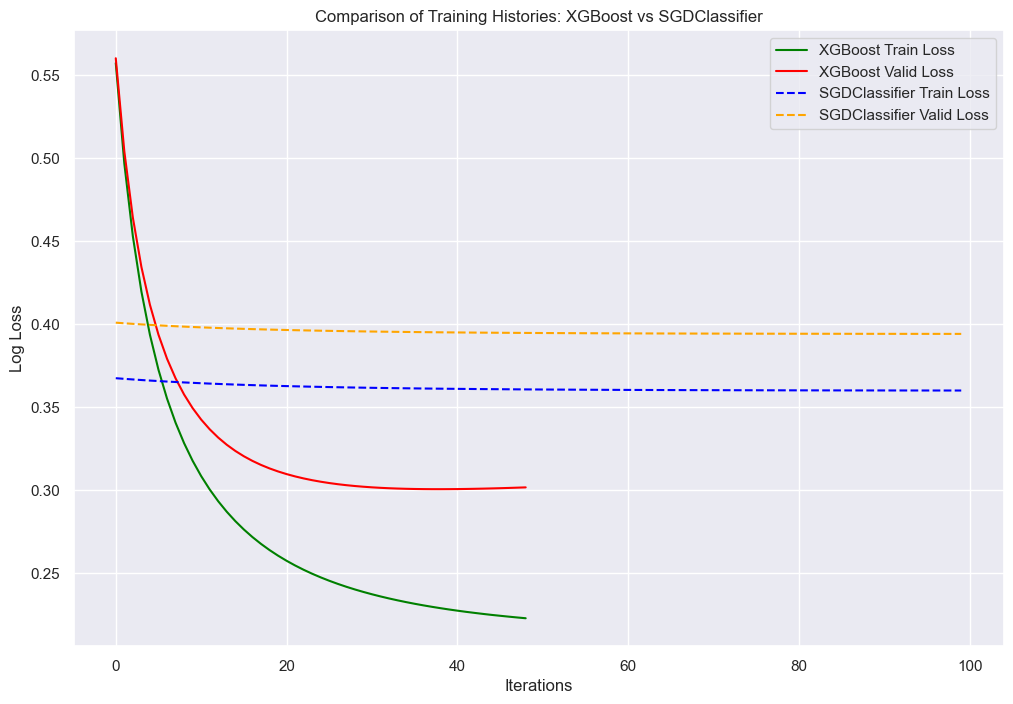

Training Time Comparison:
XGBoost: 1734811974.78 seconds
SGDClassifier: 1.00 seconds

+-------------------------+-------------+-----------------+
| Metric                  |     XGBoost |   SGDClassifier |
+=========================+=============+=================+
| Training Time (seconds) | 1.73481e+09 |          1      |
+-------------------------+-------------+-----------------+
| Train ROC-AUC           | 0.969       |          0.9263 |
+-------------------------+-------------+-----------------+
| Valid ROC-AUC           | 0.9395      |          0.906  |
+-------------------------+-------------+-----------------+


In [81]:
plt.figure(figsize=(12, 8))
plt.plot(train_loss_xgb, label='XGBoost Train Loss', linestyle='-', color='green')
plt.plot(valid_loss_xgb, label='XGBoost Valid Loss', linestyle='-', color='red')
plt.plot(train_loss_metrics_sgd, label='SGDClassifier Train Loss', linestyle='--', color='blue')
plt.plot(valid_loss_metrics_sgd, label='SGDClassifier Valid Loss', linestyle='--', color='orange')
plt.title('Comparison of Training Histories: XGBoost vs SGDClassifier')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Training Time Comparison:")
print(f"XGBoost: {train_time_xgb:.2f} seconds")
print(f"SGDClassifier: {sgd_time:.2f} seconds\n")

train_roc_auc_xgb = roc_auc_score(y_train, model_xgb.predict(train_dmatrix))
valid_roc_auc_xgb = roc_auc_score(y_valid, model_xgb.predict(valid_dmatrix))

train_roc_auc_sgd = roc_auc_score(y_train, sgd.decision_function(X_train_normalized))
valid_roc_auc_sgd = roc_auc_score(y_valid, sgd.decision_function(X_valid_normalized))

data = [
    ["Training Time (seconds)", f"{train_time_xgb:.2f}", f"{sgd_time:.2f}"],
    ["Train ROC-AUC", f"{train_roc_auc_xgb:.4f}", f"{train_roc_auc_sgd:.4f}"],
    ["Valid ROC-AUC", f"{valid_roc_auc_xgb:.4f}", f"{valid_roc_auc_sgd:.4f}"]
]

headers = ["Metric", "XGBoost", "SGDClassifier"]
print(tabulate(data, headers=headers, tablefmt="grid"))



<font color='plum'>**Вопрос:** Какой вывод вы можете сделать?</font>

<font color='plum'>**Ответ:** Прежде всего хочу сказать, что где то наверное запутался ибо график гавеный какой-то, у xgb минимум находится рановато. Но! Видимо  огромный рог аук, что показатель переобучения. Проблема ансамбля из лин. моделей, что он видимо пытался найти сложные закономерности  а  в итоге  начал подгоняться под шум в данных. Линейные модели не могут хорошо справляться с нелинейными зависимостями и ансамбль из них лишь усиливает эту проблему вместо того чтобы улучшать качество модель переобучается на трейне , теряя обобщающую способность на валиде.</font>

### 2.2. Бутстрап (0.5 балла)
Как известно, при обучении базовых алгоритмов в беггинге, используется бутстрапированная выборка. Звучит хайпово, почему бы не попробовать сделать то же самое в бустинге?

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `subsample`, — | `subsample`, `bagging`| `subsample`, `bootstrap_type`|

Вам нужно реализовать параметры:
- `subsample: float | int = 1.0` — доля или число объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float | int = 1.0` — веса объектов, которые попадают в выборку. Соответствует бутстрапу типа `Bayesian`. Каждый объект имеет определенный вес $t$, на который впоследствии домножается по формуле $w = (-\log(X))^t$, где $X \sim {U[0, 1]}$, после чего попадает в выборку. Таким образом можно сделать симуляцию повторений
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<font color='plum'>**Вопрос:** как бутстрап может помочь в обучении с точки зрения смещения, разброса и вообще?</font>

<font color='plum'>**Ответ:** С точки зрения смещеная он помогает за счет того что обучается на разных подвыборках и помогает строить сложные зависимости -> умньшает вероятность переобучения. Разброс - тк бутстрап агрегирует резы с разных подвыборок то влияение шума умньшается -> обобщ. способность лучше. Вообще - ну просто идейно это хороший варик нагенерировать себе данные, так как берем лишь один датасет а из него можем получить разные выборки так еще и можем это в свою пользу загнать (более стабильный и т.д. т.п.) + можно сделать бутстрап с повторением и сделать разнообразие в данных, главное канеш не пеерстараться</font>


Testing Bernoulli (subsample=0.3)
Early STOP at iteration 11


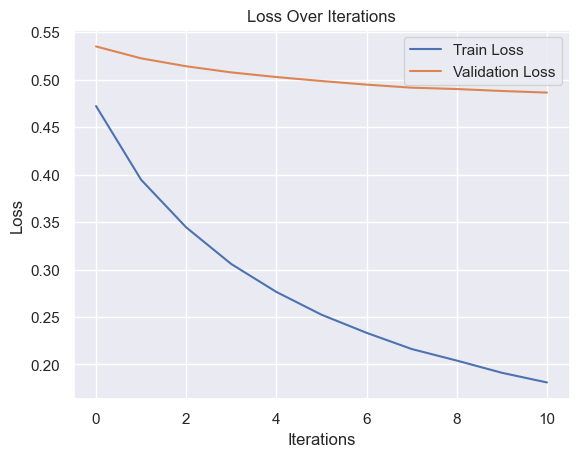

Bernoulli (subsample=0.3) Test AUC: 0.8815

Testing Bernoulli (subsample=0.8)
Early STOP at iteration 16


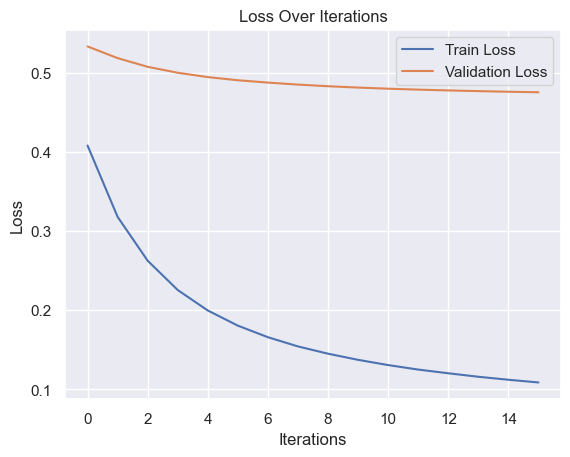

Bernoulli (subsample=0.8) Test AUC: 0.8947

Testing Bayesian (bagging_temperature=0.5)


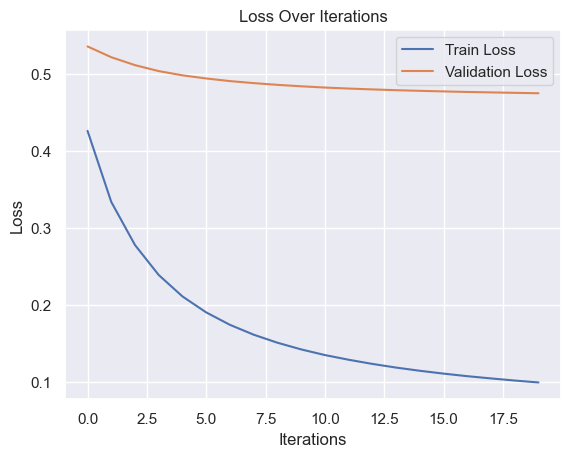

Bayesian (bagging_temperature=0.5) Test AUC: 0.8861

Testing Bayesian (bagging_temperature=1.5)


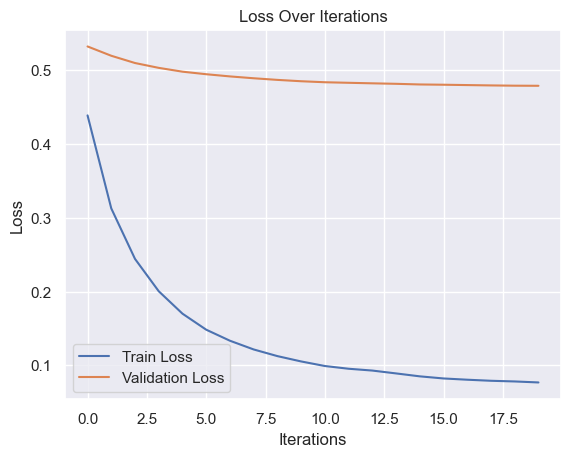

Bayesian (bagging_temperature=1.5) Test AUC: 0.8558

Summary of Bootstrap Tests:
Bernoulli (subsample=0.3): Test AUC = 0.8815
Bernoulli (subsample=0.8): Test AUC = 0.8947
Bayesian (bagging_temperature=0.5): Test AUC = 0.8861
Bayesian (bagging_temperature=1.5): Test AUC = 0.8558


In [82]:
bootstrap_tests = [
    {"name": "Bernoulli (subsample=0.3)", "subsample": 0.3, "bootstrap_type": "Bernoulli"},
    {"name": "Bernoulli (subsample=0.8)", "subsample": 0.8, "bootstrap_type": "Bernoulli"},
    {"name": "Bayesian (bagging_temperature=0.5)", "bagging_temperature": 0.5, "bootstrap_type": "Bayesian"},
    {"name": "Bayesian (bagging_temperature=1.5)", "bagging_temperature": 1.5, "bootstrap_type": "Bayesian"},
]

results = []

for test in bootstrap_tests:
    print(f"\nTesting {test['name']}")
    model = Boosting(
        n_estimators=20,
        learning_rate=0.1,
        early_stopping_rounds=5,
        subsample=test.get("subsample", 1.0),
        bagging_temperature=test.get("bagging_temperature", 1.0),
        bootstrap_type=test["bootstrap_type"]
    )
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=True)
    test_auc = model.score(X_test, y_test)
    results.append({"Configuration": test["name"], "Test AUC": test_auc})
    print(f"{test['name']} Test AUC: {test_auc:.4f}")

print("\nSummary of Bootstrap Tests:")
for result in results:
    print(f"{result['Configuration']}: Test AUC = {result['Test AUC']:.4f}")


### Бонус. GOSS (0.5 балла)

Заметим, что во время обучения не все объекты одинаково важны. Один из вариантов это исправить — ввести какие-то веса на объекты, однако можно пойти чуть хитрее. В <font color='lightgreen'>**LightGBM**</font> придумали подход [Gradient-based One-side Sampling](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

Давайте оценивать важность объектов в отдельный момент обучения нового дерева. Будем считать, какой антиградиент привносит каждый объект. Далее разобъем градиенты на 2 группы. Объекты с большими градиентами берутся все, с маленькими — только часть, по аналогии с бутстрапом, с отрицательными — выкидываются. И не забываем домножить на фактор, чтобы учесть выкинутые объекты. Подробнее в статье

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | `bagging='goss'`| `bootstrap_type='MVS'`|

Параметры, которые нужно сделать:

- `goss: bool | None = False` — GOSS бустинг или нет
- `goss_k: float | int = 0.2` — доля объектов, градиенты которых будем считать большими. Все остальное — маленькими
- `subsample: float | int = 0.3` — параметры сэмплинга для маленьких градиентов из пункта 2.1

Testing GOSS (k=0.2, subsample=0.3)
Early STOP at iteration 19


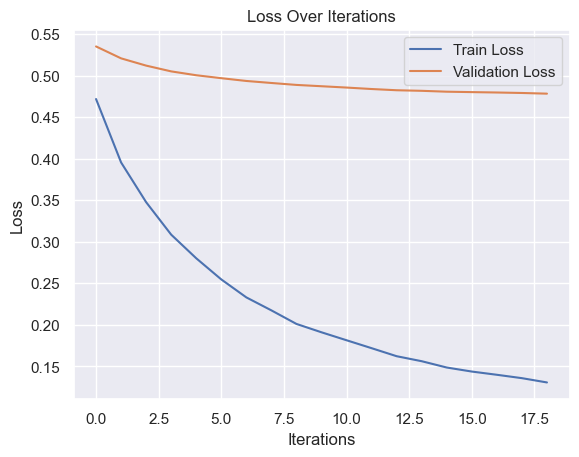

GOSS Test AUC: 0.8923909227031614


In [87]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
print("Testing GOSS (k=0.2, subsample=0.3)")
goss_model = Boosting(
    n_estimators=20,
    learning_rate=0.1,
    early_stopping_rounds=5,
    goss=True,
    goss_k=0.2,
    subsample=0.3
)
goss_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=True)
goss_score = goss_model.score(X_test, y_test)
print("GOSS Test AUC:", goss_score)


### 2.3. Работа с признаками (1 балл)

1. Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать `rsm`

2. С другой стороны, вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет. Для этого существует множество алгоритмов, мы предлагаем сделать два наиболее простых:

- $\text{Uniform}$. Значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- $\text{Quantile}$. Тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `colsample_bytree`, `tree_method` | `colsample_bytree`, `max_bin`| `rsm`, `quantize(...)`|

Нужно добавить параметры:
- `rsm: float | int = 1.0` — доля или число признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

<font color='plum'>**Вопрос**: как квантизация поможет в обработке выбросов и нанов?</font>

<font color='plum'>**Ответ**:  сглаживает влияние выбросов, группируя значения в бины и может игнорировать наны не включая их в расчет бинов </font>

<font color='plum'>**Вопрос**: можно ли просто заполнить наны каким-то числом? Имеет ли значение, что это за число (-1, -100, -1e32)?</font>

<font color='plum'>**Ответ**: можно но важно, чтобы выбранное число не влияло на обучение ибо значение должно быть вне диапазона признаков, чтобы модель не интерпретировала его как инфу которую надо учесть как полезную для обучения </font>

Testing GOSS with Quantization and RSM
Early STOP at iteration 11


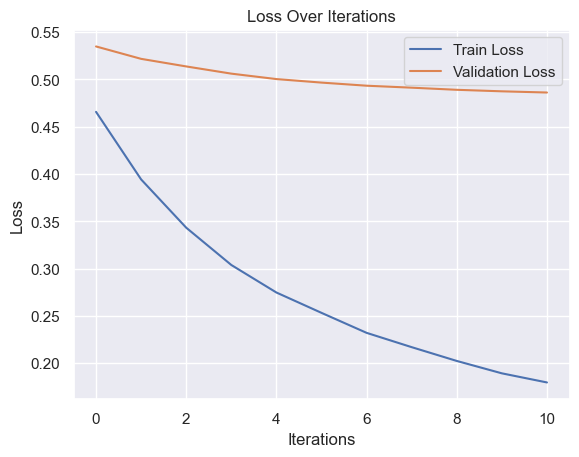

GOSS with Uniform and RSM Test AUC: 0.8721

Testing GOSS with Quantization (Quantile) and RSM
Early STOP at iteration 12


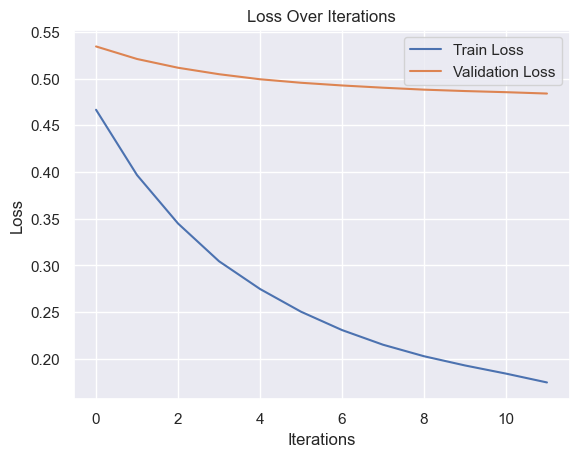

GOSS with Quantile and RSM Test AUC: 0.8848


In [ ]:
print("Testing GOSS with Uniform and RSM")
goss_model = Boosting(
    n_estimators=20,
    learning_rate=0.1,
    early_stopping_rounds=5,
    goss=True,
    goss_k=0.2,
    subsample=0.3,
    rsm=0.8,
    quantization_type='Uniform',  
    nbins=255
)
goss_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=True)

goss_score = goss_model.score(X_test, y_test)
print(f"GOSS with Uniform and RSM Test AUC: {goss_score:.4f}")

print("\nTesting GOSS with Quantile and RSM")
goss_model_quantile = Boosting(
    n_estimators=20,
    learning_rate=0.1,
    early_stopping_rounds=5,
    goss=True,
    goss_k=0.2,
    subsample=0.3,
    rsm=0.8,
    quantization_type='Quantile',
    nbins=255
)
goss_model_quantile.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=True)

goss_score_quantile = goss_model_quantile.score(X_test, y_test)
print(f"GOSS with Quantile and RSM Test AUC: {goss_score_quantile:.4f}")


### Бонус. Квантизация (1.5 балл)

В текущих имплементациях бустинга используются более сложные методы квантизации. К сожалению, способы выше страдают либо от неравноправности бинов — в каких-то объектов больше, в каких-то меньше, либо от того, что целевая переменная от бинов зависит опосредованно. Предлагается это исправить следующими способами:

1. $\text{MinEntropy}$. Это [один из методов](https://catboost.ai/docs/en/concepts/quantization), который используется для бинаризации в <font color='palegoldenrod'>**CatBoost**</font>, остальные на него очень похожи. Будем жадно набирать бины так, чтобы энтропия объектов внутри ($\sum_{i \in \text{bin}} x_i\log(x_i)$) была как можно меньше. Сделать такое разбиение руками непросто, но вам эта задача должна что-то напоминать
   
2. $\text{PiecewiseEncoding}$. Это относительно свежий метод для [табличных трансформеров](https://arxiv.org/pdf/2203.05556). Суть заключается в том, что бины для квантизации будем брать не с потолка, а именно те, что нужны для разбиения таргета. (В статье делается кодирование в вектор длины $T$, где $T$ число бинов, в нашем случае это излишне, бинов можно оставить столько же, но взять лмшь закодированную по формуле часть)

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | — | `feature_border_type="Piecewise"` |

Нужно добавить опцию:

- `'MinEntropy'` для `quantization_type` — какую квантизацию используем

Реализуйте оба способа подсчета (или один, но тогда балл неполный) и сравните, удалось ли улучшить качество?

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚ минус

### 2.4. Важность признаков (0.5 балла)

Поскольку наша базовая модель — это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными — иначе вы что-то сделали не так). Разумеется, способ не единственный, если хочется, посмотрите в документации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `model.get_score()` | `lightgbm.importance()` | `model.get_feature_importance()` |

Допишите к бустингу:
- `feature_importances_` — атрибут, который возвращает важность признаков, согласно методу выше

Покажите, какие признаки оказались самыми важными

MOST IMPORTANT FEATURES (10):
#1: feature 166 — importance: 0.5685
#2: feature 164 — importance: 0.1753
#3: feature 165 — importance: 0.0320
#4: feature 168 — importance: 0.0269
#5: feature 158 — importance: 0.0132
#6: feature 36 — importance: 0.0129
#7: feature 142 — importance: 0.0090
#8: feature 161 — importance: 0.0087
#9: feature 167 — importance: 0.0084
#10: feature 1 — importance: 0.0083


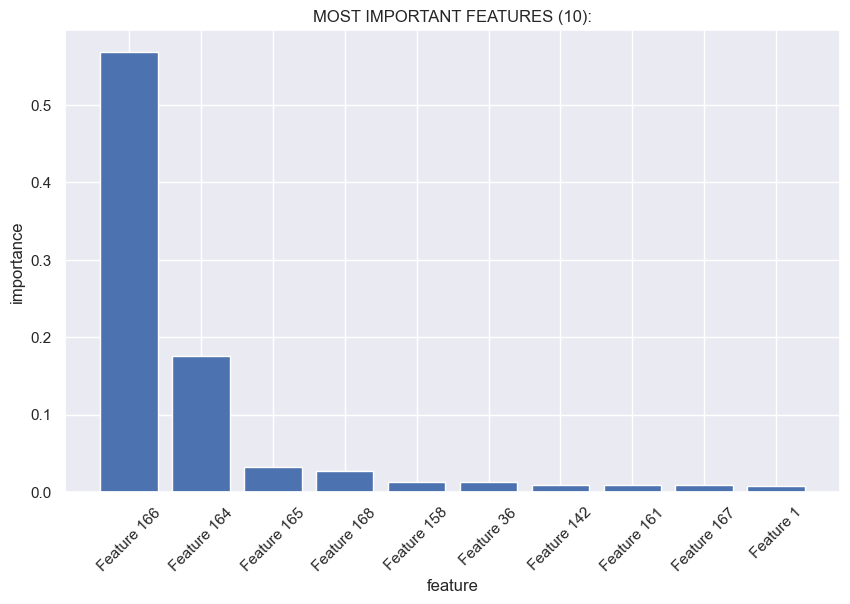

In [103]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
feature_importances = boosting.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]  
sorted_importances = feature_importances[sorted_indices]

print("MOST IMPORTANT FEATURES (10):")
for rank, idx in enumerate(sorted_indices[:10], start=1):
    print(f"#{rank}: feature {idx} — importance: {sorted_importances[rank-1]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(10), sorted_importances[:10], tick_label=[f"Feature {idx}" for idx in sorted_indices[:10]])
plt.title("MOST IMPORTANT FEATURES (10):")
plt.ylabel("importance")
plt.xlabel("feature")
plt.xticks(rotation=45)
plt.show()


### Бонус. DART (1.5 балла)

Ранее мы обсуждали, что каждый базовый алгоритм пытается исправить ошибки всего предыдущего ансамбля. Из-за этого возникает неравноправие — каждая новая модель вносит все меньший и меньший вклад. Уверенные обучатели нейросетей знают, что это может привести к переобучению. Но выход есть, и выход этот [DART](https://arxiv.org/pdf/1505.01866)!

В DL есть такой вид регуляризации, как dropout, когда некоторые узлы нейросети со случайным шансом отключаются. Можно попробовать обобщить этот подход на случай бустингов и случайно выкидывать деревья из композиции во время обучения

1. Выбираем, какие деревья убрать. При подсчете антиградиента берем не весь ансамбль, а только ту часть, что осталась
2. Домножаем выходы дерева на $1/k$, где $k$ — число удаленных деревьев, чтобы учесть тот факт, что ансамбль был не весь. Тогда вклад отдельного дерева будет не настолько большим
3. Домножаем выходы выкинутых деревьев на $k/(k+1)$, чтобы масштабы выходов примерно совпадали

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="dart")` | `LGBMClassifier(boosting_type="dart")` | — |

Параметры, которые нужно добавить:

- `dart: bool | None = False` — DART бустинг или нет
- `dropout_rate: int | float = 0.05` — доля деревьев, которую выкидываем во время обучения DART

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚ - minus

------

## Задание 3. Оптимизация (3.5 балла + 0.5 бонус)

Теперь давайте подумаем, как же правильно применять бустинги. Нас интересует: какие бустинги вообще бывают, как их правильно тюнить, и как интерпретировать

Оптимизация моделей с большим числом гиперпараметров это сложное дело. Нетрудно догадаться, что в случае, когда параметров $m$, сложность перебора в самом худшем случае будет порядка $n^m$. У бустингов, хотя на самом деле не только, эта проблема стоит особенно остро. Подумаем, как это делать умнее

### 3.1. Знакомство с optuna (1 балл)

Для эффективного подбора гиперпараметров существует несколько решений, основанных на байесовской оптимизации. В этом задании предлагается познакомиться с библиотекой [optuna](https://optuna.org/), которая делает перебор гиперпараметров легким и приятным, а также сохраняет всю историю экспериментов в одно место за вас

Подберите на валидации оптимальные значения следующих гиперпараметров для вашей реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`
- любые другие параметры, которые вам понравились

Заметим, что оптуна это крайне гибкая библиотека, в которой можно реализовать абсолютно любую логику, которую пожелаете. За вас там есть лишь выбор модели. Чтобы не плодить несколько `objective`, можно слегка менять тело функции, например, добавить опциональные параметры, но шаблоном пользоваться не обязательно, как обычно

Подберите диапазон параметров самостоятельно, не забывайте фиксировать сид (нет, его не нужно перебирать). Сохраните и покажите оптимальный набор параметров. Сравните графики функций потерь для оптимального и дефолтного бустингов. Покажите, какие параметры дали наибольший прирост (для этого придется почитать документацию оптуны)

In [105]:
%pip install optuna


  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/364.4 kB ? eta -:--:--
   --------------------------------------- 364.4/364.4 kB 11.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.5 kB ? eta -:--:--
   --------------------------------------- 233.5/233.5 kB 14.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -------------------------- ------------- 1.4/2.1 MB 86.4 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 33.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/299.7 kB ? eta -:--:--
   --------------------------------------- 299.7/299.7 kB 19.3 MB/s eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
   ---------------------------------------- 0.0/78.6 kB ? eta -:--:--
   ---------------------------------------- 78.6/78.6 kB 4.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [112]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
import optuna

def objective(trial, model="custom_boosting"):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "early_stopping_rounds": 5,
        "base_model_params": {"max_depth": trial.suggest_int("max_depth", 1, 10)},
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "rsm": trial.suggest_float("rsm", 0.5, 1.0),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli", "Bayesian"]),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 1.5),
        "random_state": 1337
    }
    
    model = Boosting(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=False)
    return model.score(X_valid, y_valid)


In [113]:
study = optuna.create_study(direction="maximize", study_name="Boosting Optimization")
study.optimize(lambda trial: objective(trial, model="custom_boosting"), n_trials=50)

print("Best trial:")
print(study.best_trial.params)

[I 2024-12-22 01:12:23,643] A new study created in memory with name: Boosting Optimization
[I 2024-12-22 01:12:24,468] Trial 0 finished with value: 0.9133048858068074 and parameters: {'n_estimators': 40, 'learning_rate': 0.020125594623063334, 'max_depth': 10, 'subsample': 0.7167012080737756, 'rsm': 0.5400262828806197, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.4329887965233135}. Best is trial 0 with value: 0.9133048858068074.


Early STOP at iteration 7


[I 2024-12-22 01:12:25,744] Trial 1 finished with value: 0.9262092393798693 and parameters: {'n_estimators': 61, 'learning_rate': 0.26733991179669914, 'max_depth': 8, 'subsample': 0.591655851978437, 'rsm': 0.5282600334940208, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.225492316210391}. Best is trial 1 with value: 0.9262092393798693.


Early STOP at iteration 13


[I 2024-12-22 01:12:29,438] Trial 2 finished with value: 0.9407881976288939 and parameters: {'n_estimators': 70, 'learning_rate': 0.034971379339511395, 'max_depth': 3, 'subsample': 0.8223977415134602, 'rsm': 0.6030520925125455, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.5674746942689411}. Best is trial 2 with value: 0.9407881976288939.


Early STOP at iteration 47


[I 2024-12-22 01:12:32,059] Trial 3 finished with value: 0.9287171554389133 and parameters: {'n_estimators': 67, 'learning_rate': 0.2040893457648007, 'max_depth': 1, 'subsample': 0.9050638841107175, 'rsm': 0.939504096758869, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3257735703899722}. Best is trial 2 with value: 0.9407881976288939.


Early STOP at iteration 41


[I 2024-12-22 01:12:33,623] Trial 4 finished with value: 0.9337150282599518 and parameters: {'n_estimators': 53, 'learning_rate': 0.06808017378696378, 'max_depth': 6, 'subsample': 0.9477573264432724, 'rsm': 0.5068112331878681, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2994193553223682}. Best is trial 2 with value: 0.9407881976288939.


Early STOP at iteration 18


[I 2024-12-22 01:12:36,718] Trial 5 finished with value: 0.9364580115625946 and parameters: {'n_estimators': 100, 'learning_rate': 0.018716862649463942, 'max_depth': 5, 'subsample': 0.6598794107512445, 'rsm': 0.6911755206047963, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.2249666054058972}. Best is trial 2 with value: 0.9407881976288939.


Early STOP at iteration 38


[I 2024-12-22 01:12:38,501] Trial 6 finished with value: 0.9376241685843206 and parameters: {'n_estimators': 32, 'learning_rate': 0.012377978317343405, 'max_depth': 4, 'subsample': 0.6300265465428814, 'rsm': 0.8359561195783185, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.0514503756065154}. Best is trial 2 with value: 0.9407881976288939.


Early STOP at iteration 26


[I 2024-12-22 01:12:39,008] Trial 7 finished with value: 0.9176179107670377 and parameters: {'n_estimators': 89, 'learning_rate': 0.034982636726616806, 'max_depth': 8, 'subsample': 0.5029654212077331, 'rsm': 0.5596560878288803, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.1804832070944717}. Best is trial 2 with value: 0.9407881976288939.


Early STOP at iteration 7


[I 2024-12-22 01:12:40,306] Trial 8 finished with value: 0.9324690521402295 and parameters: {'n_estimators': 79, 'learning_rate': 0.026391471465414137, 'max_depth': 5, 'subsample': 0.6063771954690544, 'rsm': 0.6988797689023087, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6943478464311067}. Best is trial 2 with value: 0.9407881976288939.


Early STOP at iteration 17


[I 2024-12-22 01:12:41,477] Trial 9 finished with value: 0.9210692885643976 and parameters: {'n_estimators': 84, 'learning_rate': 0.13123681805548956, 'max_depth': 9, 'subsample': 0.7575717795526785, 'rsm': 0.6458877911329874, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.6501480877648662}. Best is trial 2 with value: 0.9407881976288939.


Early STOP at iteration 11


[I 2024-12-22 01:12:42,335] Trial 10 finished with value: 0.9180589112834671 and parameters: {'n_estimators': 17, 'learning_rate': 0.07176824491313737, 'max_depth': 1, 'subsample': 0.8371329869542242, 'rsm': 0.8225468466635651, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.1608802563146336}. Best is trial 2 with value: 0.9407881976288939.
[I 2024-12-22 01:12:44,415] Trial 11 finished with value: 0.9382248072967425 and parameters: {'n_estimators': 30, 'learning_rate': 0.011512017334135734, 'max_depth': 3, 'subsample': 0.8267417557306089, 'rsm': 0.825223109519486, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.9006601753309484}. Best is trial 2 with value: 0.9407881976288939.
[I 2024-12-22 01:12:46,002] Trial 12 finished with value: 0.9365641709629297 and parameters: {'n_estimators': 24, 'learning_rate': 0.010636461125996732, 'max_depth': 3, 'subsample': 0.8301207560870891, 'rsm': 0.842032235766744, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.90883983974576

Early STOP at iteration 27


[I 2024-12-22 01:12:54,061] Trial 14 finished with value: 0.941887306608303 and parameters: {'n_estimators': 71, 'learning_rate': 0.10964106867087377, 'max_depth': 2, 'subsample': 0.9831184220845173, 'rsm': 0.7754110175123881, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.8846485657182931}. Best is trial 14 with value: 0.941887306608303.
[I 2024-12-22 01:12:58,428] Trial 15 finished with value: 0.9401256991155246 and parameters: {'n_estimators': 70, 'learning_rate': 0.11559283531491124, 'max_depth': 2, 'subsample': 0.9902780046738476, 'rsm': 0.6225101373248378, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.3942852102206203}. Best is trial 14 with value: 0.941887306608303.


Early STOP at iteration 55


[I 2024-12-22 01:13:02,129] Trial 16 finished with value: 0.9380915094030889 and parameters: {'n_estimators': 74, 'learning_rate': 0.04702171996738684, 'max_depth': 2, 'subsample': 0.9022402017383228, 'rsm': 0.7446298539393119, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.5918509246795441}. Best is trial 14 with value: 0.941887306608303.


Early STOP at iteration 49


[I 2024-12-22 01:13:07,869] Trial 17 finished with value: 0.9392508818014852 and parameters: {'n_estimators': 94, 'learning_rate': 0.10055448098971818, 'max_depth': 4, 'subsample': 0.9947641483908115, 'rsm': 0.6044418209423604, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.8045039038163686}. Best is trial 14 with value: 0.941887306608303.


Early STOP at iteration 59


[I 2024-12-22 01:13:09,115] Trial 18 finished with value: 0.9302951790063002 and parameters: {'n_estimators': 56, 'learning_rate': 0.15533595071429726, 'max_depth': 6, 'subsample': 0.7658451794997372, 'rsm': 0.7689481972703421, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.9818175341064872}. Best is trial 14 with value: 0.941887306608303.


Early STOP at iteration 16


[I 2024-12-22 01:13:14,494] Trial 19 finished with value: 0.9407586645626353 and parameters: {'n_estimators': 64, 'learning_rate': 0.07820723395286826, 'max_depth': 2, 'subsample': 0.8920202268545978, 'rsm': 0.9021507564342743, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.7851799488784778}. Best is trial 14 with value: 0.941887306608303.
[I 2024-12-22 01:13:16,739] Trial 20 finished with value: 0.9364560160851446 and parameters: {'n_estimators': 79, 'learning_rate': 0.053970363131784924, 'max_depth': 4, 'subsample': 0.7038358114477461, 'rsm': 0.7624226602860209, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.4988838276205404}. Best is trial 14 with value: 0.941887306608303.


Early STOP at iteration 31


[I 2024-12-22 01:13:22,062] Trial 21 finished with value: 0.940913114517258 and parameters: {'n_estimators': 64, 'learning_rate': 0.08999660182421532, 'max_depth': 2, 'subsample': 0.9090516041791479, 'rsm': 0.9241238742370812, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.7654656133248}. Best is trial 14 with value: 0.941887306608303.
[I 2024-12-22 01:13:25,321] Trial 22 finished with value: 0.9296897511479981 and parameters: {'n_estimators': 48, 'learning_rate': 0.08412698317073944, 'max_depth': 1, 'subsample': 0.941405848214414, 'rsm': 0.8992901717386628, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.7921193845350203}. Best is trial 14 with value: 0.941887306608303.
[I 2024-12-22 01:13:31,753] Trial 23 finished with value: 0.9419220279159313 and parameters: {'n_estimators': 73, 'learning_rate': 0.030650662551042557, 'max_depth': 2, 'subsample': 0.9475017494344816, 'rsm': 0.6929995010087033, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.0814643465632399}.

Early STOP at iteration 44


[I 2024-12-22 01:13:48,094] Trial 27 finished with value: 0.9345575188393026 and parameters: {'n_estimators': 86, 'learning_rate': 0.17850238071881808, 'max_depth': 4, 'subsample': 0.9981253655013731, 'rsm': 0.725056834664887, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.3054159767503242}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 25


[I 2024-12-22 01:13:51,426] Trial 28 finished with value: 0.9397110389014337 and parameters: {'n_estimators': 43, 'learning_rate': 0.2921543143372007, 'max_depth': 3, 'subsample': 0.9531642727711693, 'rsm': 0.7936309152348835, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.423304388035526}. Best is trial 23 with value: 0.9419220279159313.
[I 2024-12-22 01:13:53,195] Trial 29 finished with value: 0.9298845097471091 and parameters: {'n_estimators': 37, 'learning_rate': 0.019121665043593698, 'max_depth': 5, 'subsample': 0.8709179188008318, 'rsm': 0.868647770667068, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8840631202381682}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 22


[I 2024-12-22 01:13:54,105] Trial 30 finished with value: 0.9298932898478888 and parameters: {'n_estimators': 62, 'learning_rate': 0.12113435573163339, 'max_depth': 7, 'subsample': 0.933245747315163, 'rsm': 0.6701945771904818, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.1169035618928935}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 10


[I 2024-12-22 01:13:58,840] Trial 31 finished with value: 0.941366486993877 and parameters: {'n_estimators': 59, 'learning_rate': 0.0955575516568284, 'max_depth': 2, 'subsample': 0.9194609182918324, 'rsm': 0.9394784295733285, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.9720842622586058}. Best is trial 23 with value: 0.9419220279159313.
[I 2024-12-22 01:14:03,089] Trial 32 finished with value: 0.9392656483346143 and parameters: {'n_estimators': 58, 'learning_rate': 0.0593858455321926, 'max_depth': 2, 'subsample': 0.9760424438551685, 'rsm': 0.9996253275205885, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.9605775780311522}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 54


[I 2024-12-22 01:14:06,368] Trial 33 finished with value: 0.9285742792535 and parameters: {'n_estimators': 72, 'learning_rate': 0.10063681151920352, 'max_depth': 10, 'subsample': 0.9202819657014861, 'rsm': 0.946839556147818, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.1014478571405335}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 23


[I 2024-12-22 01:14:09,815] Trial 34 finished with value: 0.9316305525157782 and parameters: {'n_estimators': 50, 'learning_rate': 0.2167427306076661, 'max_depth': 1, 'subsample': 0.8726092368567578, 'rsm': 0.9651866813265483, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.498715312021837}. Best is trial 23 with value: 0.9419220279159313.
[I 2024-12-22 01:14:13,285] Trial 35 finished with value: 0.9403703446508833 and parameters: {'n_estimators': 68, 'learning_rate': 0.02762017208128233, 'max_depth': 3, 'subsample': 0.9644493148502925, 'rsm': 0.8847037974249465, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.304957508248083}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 44


[I 2024-12-22 01:14:17,760] Trial 36 finished with value: 0.9324171697265319 and parameters: {'n_estimators': 61, 'learning_rate': 0.14190408722692685, 'max_depth': 1, 'subsample': 0.7967896845376338, 'rsm': 0.7924121845288445, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.2406532123461715}. Best is trial 23 with value: 0.9419220279159313.
[I 2024-12-22 01:14:20,499] Trial 37 finished with value: 0.9357428324445478 and parameters: {'n_estimators': 74, 'learning_rate': 0.04444017087153548, 'max_depth': 2, 'subsample': 0.926989054540864, 'rsm': 0.938674725860335, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8674837929833953}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 39


[I 2024-12-22 01:14:23,427] Trial 38 finished with value: 0.9386654087176822 and parameters: {'n_estimators': 66, 'learning_rate': 0.0284299702898706, 'max_depth': 3, 'subsample': 0.6992203764872207, 'rsm': 0.9722185777168729, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.0513734599476745}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 40


[I 2024-12-22 01:14:26,708] Trial 39 finished with value: 0.9385041741397298 and parameters: {'n_estimators': 58, 'learning_rate': 0.1823561466375905, 'max_depth': 4, 'subsample': 0.5071515545166383, 'rsm': 0.5672969598651008, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 1.1790051849488183}. Best is trial 23 with value: 0.9419220279159313.


Early STOP at iteration 43


[I 2024-12-22 01:14:30,352] Trial 40 finished with value: 0.9313914943172794 and parameters: {'n_estimators': 52, 'learning_rate': 0.014584875151028617, 'max_depth': 1, 'subsample': 0.7898474859285693, 'rsm': 0.7196044110156551, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9614231464983927}. Best is trial 23 with value: 0.9419220279159313.
[I 2024-12-22 01:14:35,313] Trial 41 finished with value: 0.9398443367950876 and parameters: {'n_estimators': 61, 'learning_rate': 0.09601023365257284, 'max_depth': 2, 'subsample': 0.9089685190748132, 'rsm': 0.921408900479676, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.7487570891351216}. Best is trial 23 with value: 0.9419220279159313.
[I 2024-12-22 01:14:41,022] Trial 42 finished with value: 0.9418517871096945 and parameters: {'n_estimators': 67, 'learning_rate': 0.06327245938314655, 'max_depth': 2, 'subsample': 0.9714050786568793, 'rsm': 0.8595103188283268, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.7273807298515

Early STOP at iteration 45


[I 2024-12-22 01:14:51,944] Trial 44 finished with value: 0.942100423599953 and parameters: {'n_estimators': 83, 'learning_rate': 0.04994110481444291, 'max_depth': 2, 'subsample': 0.9724372548186401, 'rsm': 0.7987778670693747, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.8455848770777038}. Best is trial 44 with value: 0.942100423599953.


Early STOP at iteration 80


[I 2024-12-22 01:14:59,115] Trial 45 finished with value: 0.9350679619709891 and parameters: {'n_estimators': 83, 'learning_rate': 0.05019950097927591, 'max_depth': 1, 'subsample': 0.9785606939488534, 'rsm': 0.7920850988728332, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.8404639198375562}. Best is trial 44 with value: 0.942100423599953.
[I 2024-12-22 01:15:02,100] Trial 46 finished with value: 0.9390054380751465 and parameters: {'n_estimators': 92, 'learning_rate': 0.022585283348339334, 'max_depth': 3, 'subsample': 0.9730616023631637, 'rsm': 0.6631169284283659, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.7190895868459322}. Best is trial 44 with value: 0.942100423599953.


Early STOP at iteration 39


[I 2024-12-22 01:15:11,489] Trial 47 finished with value: 0.943158824839384 and parameters: {'n_estimators': 99, 'learning_rate': 0.03998818365753679, 'max_depth': 2, 'subsample': 0.8786007064782463, 'rsm': 0.8059897433041594, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.6221699135388683}. Best is trial 47 with value: 0.943158824839384.


Early STOP at iteration 95


[I 2024-12-22 01:15:13,270] Trial 48 finished with value: 0.9319506270987434 and parameters: {'n_estimators': 98, 'learning_rate': 0.03672159728271928, 'max_depth': 7, 'subsample': 0.8805651580534808, 'rsm': 0.822446846119736, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.6200843897685996}. Best is trial 47 with value: 0.943158824839384.


Early STOP at iteration 19


[I 2024-12-22 01:15:15,796] Trial 49 finished with value: 0.9386171181633945 and parameters: {'n_estimators': 89, 'learning_rate': 0.03137126225616463, 'max_depth': 3, 'subsample': 0.8526259956114541, 'rsm': 0.7994093517169448, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.5021436856010626}. Best is trial 47 with value: 0.943158824839384.


Early STOP at iteration 35
Best trial:
{'n_estimators': 99, 'learning_rate': 0.03998818365753679, 'max_depth': 2, 'subsample': 0.8786007064782463, 'rsm': 0.8059897433041594, 'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.6221699135388683}


Early STOP at iteration 82


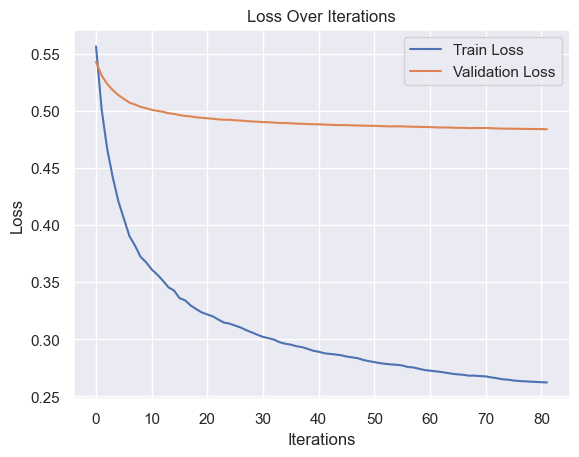

Early STOP at iteration 9


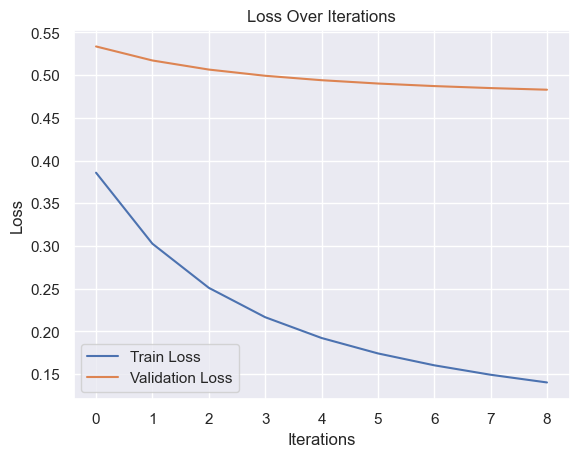

In [114]:
best_params = study.best_trial.params

optimized_model = Boosting(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    early_stopping_rounds=5,
    base_model_params={"max_depth": best_params["max_depth"]},
    subsample=best_params["subsample"],
    rsm=best_params["rsm"],
    bootstrap_type=best_params["bootstrap_type"],
    bagging_temperature=best_params["bagging_temperature"],
)
optimized_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=True)

default_model = Boosting(n_estimators=100, learning_rate=0.1, early_stopping_rounds=5)
default_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=True)

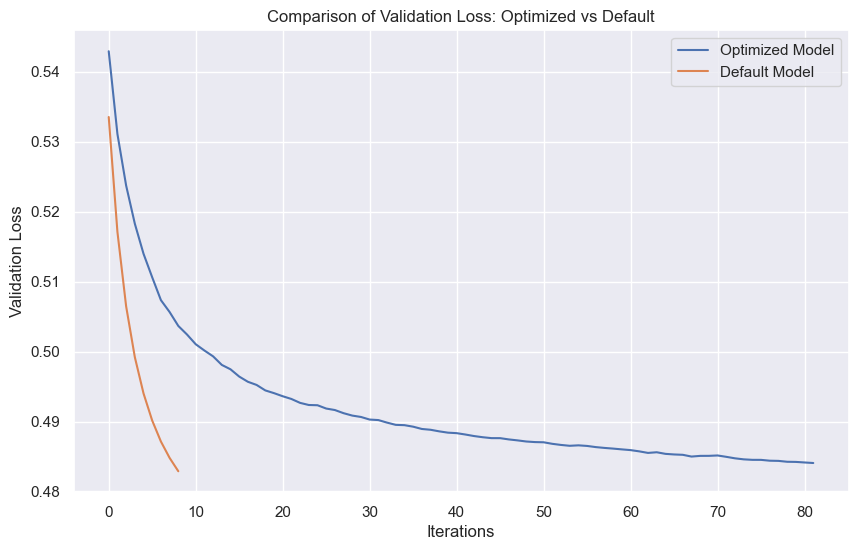

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(optimized_model.history["val_loss"], label="Optimized Model")
plt.plot(default_model.history["val_loss"], label="Default Model")
plt.xlabel("Iterations")
plt.ylabel("Validation Loss")
plt.title("Comparison of Validation Loss: Optimized vs Default")
plt.legend()
plt.show()

Можно заметить что не оптимизированная модель достигает минимума (локального тут), в то время как оптимизированная портатила больше итераций но сошлась к меньшей ошибки. Учитывая скорость функций библиотеки, очев ее лучше юзать.

### 3.2. Глубокая оптимизация (1 балл)

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения. Улучшите процедуру оптимизации следующим образом:

1. Посмотрите, как в `optuna` устроена запись в хранилища, и добавьте это в пайплайн оптимизации. Без указания БД все запуски оптуны сотрутся, как только закончится сессия. Более того, так можно распараллелить процесс оптимизации на несколько машин
2. Посмотрите, как можно контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые, их можно использовать пунктом ниже. Для кастомной модели возьмите что-то из `optuna.pruners`. Идея прунера — не обучать бустинг до конца, если по истории видно, что другие бустинги на этом этапе статистически лучше.
3. Добавьте сохранение истории функции потерь и времени обучения в качестве `user_attribute` сразу в `study`. Мы не хотим оптимизировать их напрямую, но они нам понадобится для сравнения моделей в дальнейшем

Добавьте хранилище и юзер атрибуты и посмотрите, ускорилась ли оптимизация с добавлением прунера

In [122]:
def objective(trial):
    start_time = time.time()

    # Тут канеш параметров поменьше, но я не хочу ждать 100 лет прошу простить
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "rsm": trial.suggest_float("rsm", 0.5, 1.0),
        "random_state": 1337
    }

    model = Boosting(
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        base_model_params={"max_depth": params["max_depth"]},
        subsample=params["subsample"],
        rsm=params["rsm"],
    )

    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=False)
    valid_loss = model.history["val_loss"][-1]
    trial.set_user_attr("training_time", time.time() - start_time)
    trial.set_user_attr("validation_loss_history", model.history["val_loss"])
    trial.set_user_attr("training_loss_history", model.history["train_loss"])
    return valid_loss


In [125]:
storage = "sqlite:///optuna_study.db" # sqlite база данных для хранения результатов оптимизации вроде легально так делать (я прост долго вникал что ваще надо тут делать)
study = optuna.create_study(
    study_name="boosting_optimization_with_pruner",
    direction="minimize",
    storage=storage,
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10) # медианный прунер смотрит если промежуточ резы модели хуже медианы то отсекает 
)

study.optimize(objective, n_trials=50)

best_trial = study.best_trial

[I 2024-12-22 01:53:43,273] Using an existing study with name 'boosting_optimization_with_pruner' instead of creating a new one.
[I 2024-12-22 01:53:55,723] Trial 165 finished with value: 0.4680024586644413 and parameters: {'n_estimators': 82, 'learning_rate': 0.06818808026688689, 'max_depth': 10, 'subsample': 0.5914064971918739, 'rsm': 0.9833487772316389}. Best is trial 160 with value: 0.46707999341178436.
[I 2024-12-22 01:54:07,800] Trial 166 finished with value: 0.4689316293454979 and parameters: {'n_estimators': 81, 'learning_rate': 0.06723771523671071, 'max_depth': 10, 'subsample': 0.5902921569454125, 'rsm': 0.9848420688545099}. Best is trial 160 with value: 0.46707999341178436.
[I 2024-12-22 01:54:20,266] Trial 167 finished with value: 0.4669658325131483 and parameters: {'n_estimators': 83, 'learning_rate': 0.0750395855336308, 'max_depth': 10, 'subsample': 0.5927740022639626, 'rsm': 0.9797903052266514}. Best is trial 167 with value: 0.4669658325131483.
[I 2024-12-22 01:54:32,396]

In [126]:
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params: ")
params_table = [[key, value] for key, value in best_trial.params.items()]
print(tabulate(params_table, headers=["Parameter", "Value"], tablefmt="grid"))

print("\nUser Attributes:")
print(f"  Training Time: {best_trial.user_attrs['training_time']:.2f} seconds")
loss_history_table = [
    ["Train", best_trial.user_attrs['training_loss_history'][-1]],
    ["Valid", best_trial.user_attrs['validation_loss_history'][-1]]
]
print(tabulate(loss_history_table, headers=["Loss Type", "Value"], tablefmt="grid"))

Best trial:
  Value: 0.4665815816271021
  Params: 
+---------------+-------------+
| Parameter     |       Value |
+===============+=============+
| n_estimators  | 100         |
+---------------+-------------+
| learning_rate |   0.0989976 |
+---------------+-------------+
| max_depth     |  10         |
+---------------+-------------+
| subsample     |   0.599229  |
+---------------+-------------+
| rsm           |   0.960108  |
+---------------+-------------+

User Attributes:
  Training Time: 16.49 seconds
+-------------+-----------+
| Loss Type   |     Value |
+=============+===========+
| Train       | 0.0976711 |
+-------------+-----------+
| Valid       | 0.466582  |
+-------------+-----------+


Либо я в ночи уже что то пропустил, но вайб будто ниче не ускорилось соотвественно идем дальше 

### 3.3. Готовые реализации (1 балл)

Библиотек для бустингов существует много, но активно используются лишь три. Ваша задача — попробовать их в деле, посмотреть на их уникальные фишки и понять, что вам нравится больше всего

Возьмите любую из популярных библиотек: <font color='lightblue'>`xgboost`</font>, <font color='lightgreen'>`lightgbm`</font>, <font color='palegoldenrod'>`catboost`</font>.
Ваша задача — взять одну из них, подобрать те же оптимальные параметры, что и выше, плюс что-то, что вам понравилось в них больше всего (может быть абсолютно любая фишка из пунктов выше или что-то, что вы найдете сами, не обязательно эксклюзивное), и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения

In [127]:
%pip install  CatBoost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.9/101.7 MB ? eta -:--:--
   - -------------------------------------- 3.0/101.7 MB 47.3 MB/s eta 0:00:03
   - -------------------------------------- 4.6/101.7 MB 41.8 MB/s eta 0:00:03
   -- ------------------------------------- 6.4/101.7 MB 40.6 MB/s eta 0:00:03
   --- ------------------------------------ 8.1/101.7 MB 39.5 MB/s eta 0:00:03
   --- ------------------------------------ 9.4/101.7 MB 35.4 MB/s eta 0:00:03
   --- ------------------------------------ 9.4/101.7 MB 35.4 MB/s eta 0:00:03
   --- ------------------------------------ 9.4/101.7 MB 35.4 MB/s eta 0:00:03
   --- ------------------------------------ 9.4/101.7 MB 35.4 MB/s eta 0:00:03
   --- ------------------------------------ 9.4/101.7 MB 35.4 MB/s eta 0:00:03
   --- ------------------------------------ 9.4/101.7 MB 35.4 MB/s eta 0:00:03
   --- ------------------------------------ 9.4/101.7 MB 35.4 MB/s e


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [128]:
from catboost import CatBoost, Pool

train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

# Тута вроде лучшие параметры
catboost_params = {
    'iterations': best_params['n_estimators'],
    'learning_rate': best_params['learning_rate'],
    'depth': best_params['max_depth'],
    'subsample': best_params['subsample'],
    'rsm': best_params['rsm'],
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': 1337,
    'verbose': False
}

start_time = time.time()
model_catboost = CatBoost(params=catboost_params)
model_catboost.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True
)
catboost_time = time.time() - start_time

start_time = time.time()
boosting = Boosting(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    base_model_params={'max_depth': best_params['max_depth']},
    subsample=best_params['subsample'],
    rsm=best_params['rsm']
)
boosting.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], plot=False)
custom_time = time.time() - start_time


In [131]:
summary_data = [
    ["Training Time (seconds)", f"{catboost_time:.2f}", f"{custom_time:.2f}"],
    ["Train AUC", f"{roc_auc_score(y_train, model_catboost.predict(X_train, prediction_type='Probability')[:, 1]):.4f}", f"{boosting.score(X_train, y_train):.4f}"],
    ["Valid AUC", f"{roc_auc_score(y_valid, model_catboost.predict(X_valid, prediction_type='Probability')[:, 1]):.4f}", f"{boosting.score(X_valid, y_valid):.4f}"]
]

headers = ["Metric", "CatBoost", "Custom Boosting"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))


+-------------------------+------------+-------------------+
| Metric                  |   CatBoost |   Custom Boosting |
+=========================+============+===================+
| Training Time (seconds) |     0.97   |            9.9    |
+-------------------------+------------+-------------------+
| Train AUC               |     0.953  |            0.9714 |
+-------------------------+------------+-------------------+
| Valid AUC               |     0.9314 |            0.9435 |
+-------------------------+------------+-------------------+


<font color='plum'>**Вопрос:** Какая архитектура вам нравится больше всего и почему?</font>

<font color='plum'>**Ответ**: ну я чисто соевый поэтому взял катбуст, наша разработка так сказать. если чуть серьезнее то просто слышал что она лучше всего справляется с град бустингом поэтому не думая взял ее </font>

### Бонус. Random Forest (0.5 балла)

Если очень захотеть, оптуна может оптимизировать все, что угодно, даже нейросети. Давайте противопоставим бустингу его злейшего врага — алгоритм Random Forest.

Возьмите реализацию случайного леса из <font color='lightgreen'>`lightgbm`</font>. Посмотрите, какие там есть гиперпараметры, переберите что-либо из них вместе с `max_depth` и `n_estimators`.

Сравните его качество и динамику функции потерь (на обучающей и на валидационной выборке) с таковыми у бустинга и сделайте вывод, а нужен ли Random Forest?

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚ не

### 3.4. Бустинг и вероятности (0.5 балла)

С качеством мы более-менее разобрались, но что насчет вероятностей? Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности?

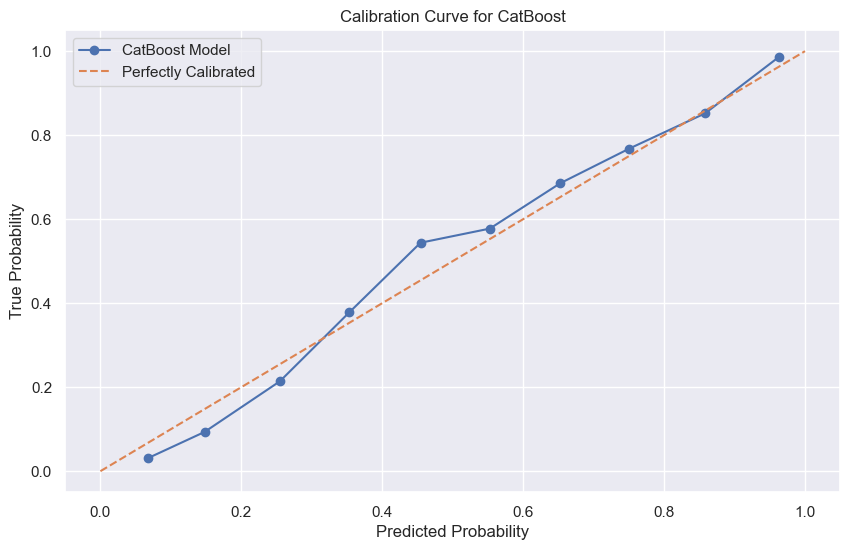

In [139]:
from sklearn.calibration import calibration_curve

y_prob = model_catboost.predict(X_valid, prediction_type="Probability")[:, 1]

prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='CatBoost Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Curve for CatBoost')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid(True)
plt.show()


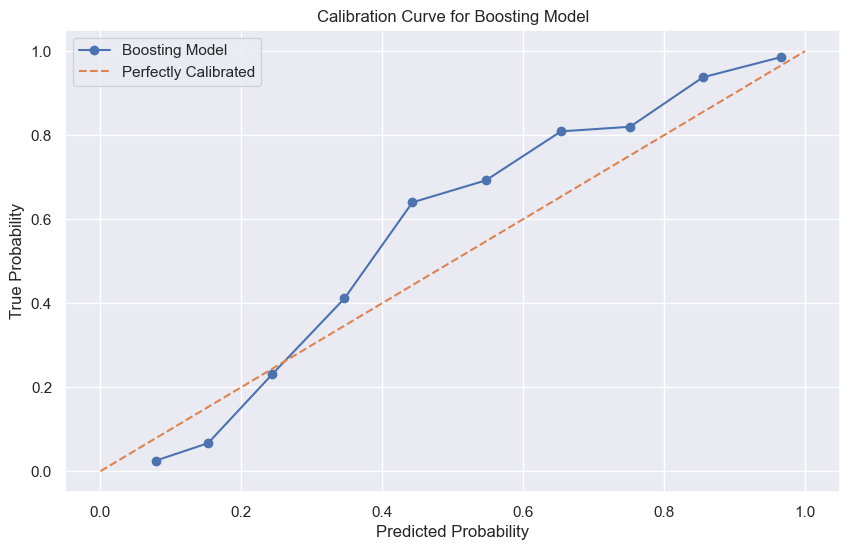

In [137]:
from sklearn.calibration import calibration_curve

y_prob_boosting = optimized_model.predict_proba(X_valid)[:, 1]

prob_true_boosting, prob_pred_boosting = calibration_curve(y_valid, y_prob_boosting, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_boosting, prob_true_boosting, marker='o', label='Boosting Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Curve for Boosting Model')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid(True)
plt.show()

**Так ну я не понял можно было ли выводить катбуст с моими лучшими параметрамм или нет , поэтому вывел один фулл кастом лучший второй катбуст с лучшими параметрами. Могу сказать что мой вариант оценивает вероятности с натяжкой неплохо, очевидно плохой назвать я не могу, но есть шатания снизу и к середине. А вот у катбуста с лучшими параметрами ваще все збс, прямо репрезентативно и можно в прод**


Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

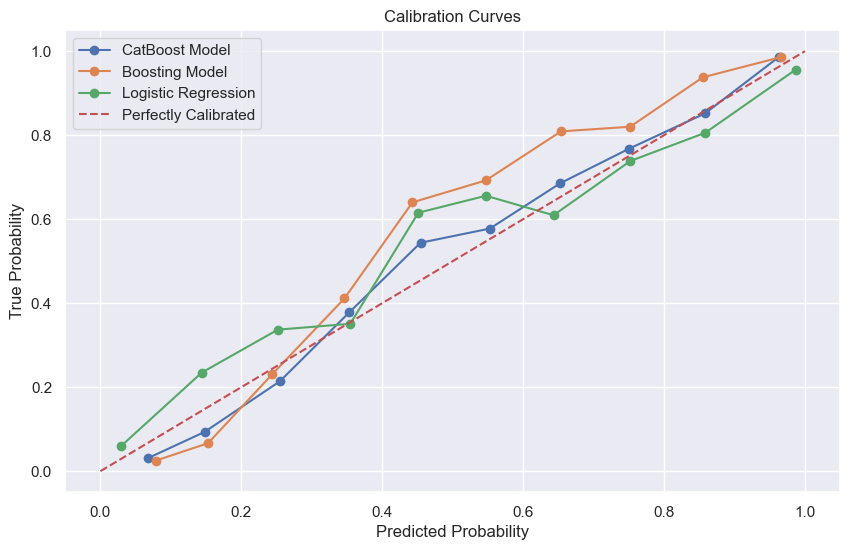

In [138]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=1337)
log_reg.fit(X_train_normalized, y_train)

y_prob_log_reg = log_reg.predict_proba(X_valid_normalized)[:, 1]

prob_true_log_reg, prob_pred_log_reg = calibration_curve(y_valid, y_prob_log_reg, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='CatBoost Model')
plt.plot(prob_pred_boosting, prob_true_boosting, marker='o', label='Boosting Model')
plt.plot(prob_pred_log_reg, prob_true_log_reg, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Curves')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid(True)
plt.show()

**Видно что лог рег тоже шатается причем его конкретно шатает похуже моего бустинга, вот по такому я бы уже вряд ли отталкивался, а катбуст великая библиотека показывает хорошую уверенность в своих прогнозах**

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2025 года?

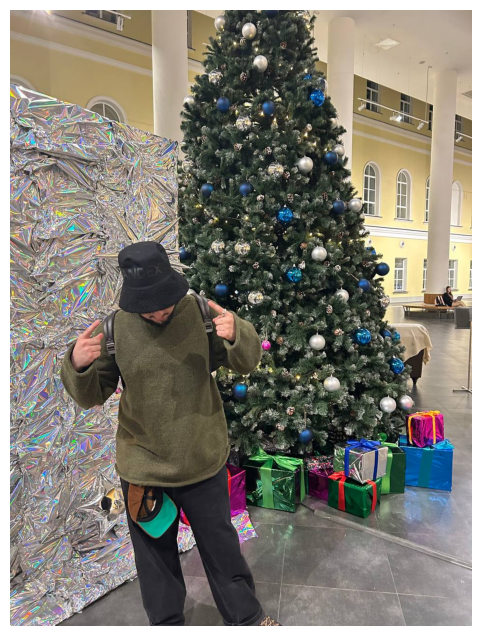

In [85]:
from PIL import Image

import matplotlib.pyplot as plt

img = Image.open('bonuska.jpg')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  
plt.show()

Я ожидаю кеглю гинесса

# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚